In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pkg_resources import resource_filename
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

the published results

In [2]:
#becker13 
b13 = np.load('/Users/jsmonzon/lbg_da/data/tau_eff/literature/Becker_2013.npy')
#schaye03
s03 = np.load('/Users/jsmonzon/lbg_da/data/tau_eff/literature/Schaye_2003.npy')
#kirkman05
k05 = np.load('/Users/jsmonzon/lbg_da/data/tau_eff/literature/Kirkman_2005.npy')
#thomas17
t17 = np.load('/Users/jsmonzon/lbg_da/data/tau_eff/literature/Thomas_2017.npy')

In [3]:
m20 = np.load('/Users/jsmonzon/lbg_da/data/tau_eff/tau_data.npy')
m20_cov = np.load('/Users/jsmonzon/lbg_da/data/tau_eff/covariance.npy')
m20_sig = np.sqrt(np.diagonal(m20_cov))

In [6]:
#
all_z = np.concatenate([s03[0,:], k05[0,:], b13[0,:], m20[0,:]])
all_tau = np.concatenate([s03[1,:], k05[1,:], b13[1,:], m20[1,:]])
all_sig = np.concatenate([s03[2,:], k05[2,:], b13[2,:], m20_sig])

In [7]:
# Cut
gdz = all_z < 4.0
cut = gdz
all_z = all_z[cut]
all_tau = all_tau[cut]
all_sig = all_sig[cut]

In [8]:
X = np.atleast_2d(all_z).T
X.shape

(154, 1)

In [9]:
# Remove the mean
mean_tau = np.mean(all_tau)
norm_tau = all_tau - mean_tau

In [10]:
scale_z = 100.
scale_tau = 100.
#
scale_z = 1.
scale_tau = 1.

In [11]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(0.1, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9,
                             alpha=all_sig**2)

In [12]:
gp.fit(X*scale_z, norm_tau*scale_tau)

GaussianProcessRegressor(alpha=array([2.56000000e-04, 2.56000000e-04, 6.76000000e-04, 6.76000000e-04,
       1.08900000e-03, 3.61000000e-04, 3.61000000e-04, 6.76000000e-04,
       7.29000000e-04, 3.24000000e-04, 4.41000000e-04, 3.24000000e-04,
       1.96000000e-04, 4.41000000e-04, 3.61000000e-04, 4.84000000e-04,
       4.00000000e-04, 8.41000000e-04, 6.25000000e-04, 4.84000000e-04,
       8.41000000e-...
       3.76547355e-03, 3.96786813e-03, 4.19833435e-03, 2.81379476e-03,
       3.16381834e-03, 3.26289962e-03, 4.13085037e-03, 1.98834480e-03,
       2.22518455e-03, 2.09718260e-03, 2.08679200e-03, 2.26184942e-03,
       2.60157494e-03, 2.78444396e-03, 1.96297663e-03, 2.37262246e-03,
       1.67205674e-03, 1.52376755e-03]),
                         copy_X_train=True, kernel=1**2 * RBF(length_scale=0.1),
                         n_restarts_optimizer=9, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [30]:
#prediction
x = np.atleast_2d(np.linspace(1.4, 4.1, 1000)).T
y_pred, sigma = gp.predict(x*scale_z, return_std=True)

In [31]:
# GP
xv = x[:,0]

# Fill between
x2 = xv[::-1]
xp = np.hstack((xv, x2))
y2 = y_pred-sigma+mean_tau
y2 = y2[::-1]
yp = np.hstack((y_pred+sigma+mean_tau,y2))

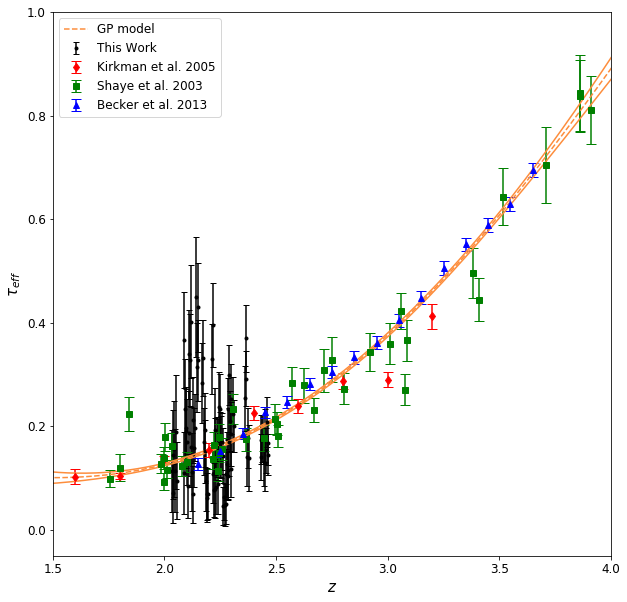

In [46]:
# Plot

plt.figure(figsize=(10,10))

plt.errorbar(m20[0,:], m20[1,:], yerr=m20_sig, fmt=".", label="This Work",color="black", capsize=3)

plt.errorbar(k05[0,:], k05[1,:], yerr = k05[2,:],
             capsize=5,label="Kirkman et al. 2005",
             ls="none",color="red", marker="d")
                 
plt.errorbar(s03[0,:], s03[1,:], yerr = s03[2,:],
             capsize=5,label="Shaye et al. 2003",
             ls="none",color="green", marker="s")  
            

plt.errorbar(b13[0,:], b13[1,:], yerr = b13[2,:],
             capsize=5,label="Becker et al. 2013",
             ls="none",color="blue", marker="^")

plt.plot(x[:,0], (y_pred+mean_tau)/scale_tau, color='#fd8d3c', label='GP model', ls="--")
plt.plot(xp, yp, color="#fd8d3c")


plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(-.05, 1.0)
plt.xlim(1.5, 4.0)
plt.xlabel("$z$",fontsize=15)
plt.ylabel("$τ_{eff}$",fontsize=15)
plt.savefig("/Users/jsmonzon/lbg_da/figures/tau_evo.pdf")
plt.show()